In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

#### AutoEncoder Usecases:

    1. Dimensionality Reduction
    2. Visualization
    3. Image denoising 
    4. Anomaly detection.
    
An autoencoder learns to compress the data while minimizing the reconstruction error.

#### Load the dataset

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


**Define an autoencoder** with two Dense layers: 

**encoder** => which compresses the images into a 64 dimensional latent vector

**decoder** => that reconstructs the original image from the latent space.

In [4]:
latent_dim = 64 

class Autoencoder(Model):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(784, activation='sigmoid'),
          layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(latent_dim) 

In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 2s 904us/step - loss: 0.0241 - val_loss: 0.0135
Epoch 2/10
1875/1875 [==============================] - 2s 840us/step - loss: 0.0116 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 2s 829us/step - loss: 0.0101 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 2s 861us/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 2s 840us/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 2s 841us/step - loss: 0.0090 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 2s 869us/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 2s 844us/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 2s 851us/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 2s 874u

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

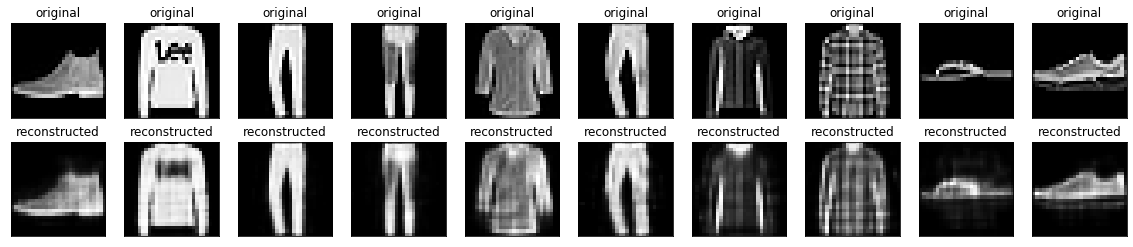

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Image denoising

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [10]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

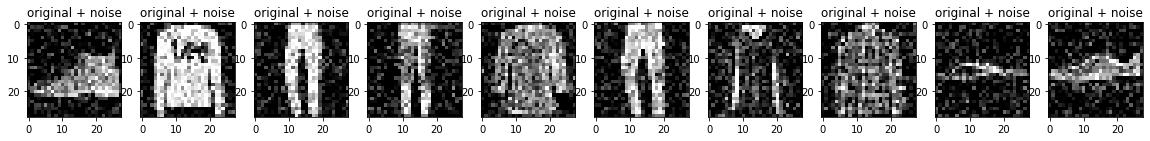

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

#### Define a convolutional autoencoder

In [12]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)), 
          layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0190 - val_loss: 0.0114
Epoch 2/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 3/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 50s 26ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 5/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 6/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 7/10
 171/1875 [=>............................] - ETA: 37s - loss: 0.0084

KeyboardInterrupt: 

In [14]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

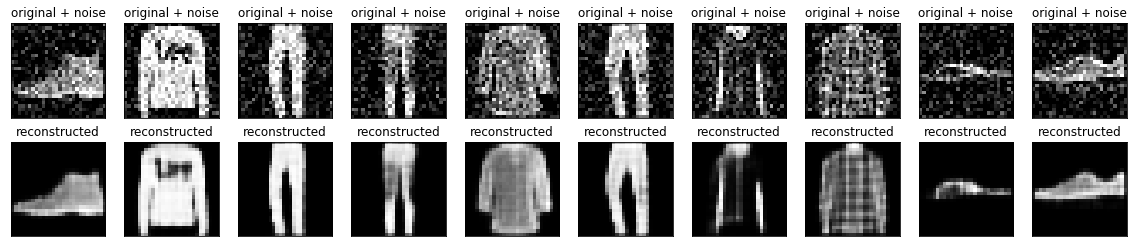

In [15]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

**Anomaly detection**

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.



In [19]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head(10)

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
5,-1.507674,-3.574550,-4.478011,-4.408275,-3.321242,-2.105171,-1.481048,-1.301362,-0.498240,-0.286928,...,1.089068,0.983369,1.014124,0.952629,0.749326,1.007076,1.634990,1.493366,-0.783134,1.0
6,-0.297161,-2.766635,-4.102185,-4.589669,-4.219357,-3.650443,-2.300518,-1.293917,-1.065658,-0.490520,...,0.581779,0.684406,0.911651,0.979483,1.053458,0.974787,1.110407,1.288165,-0.823386,1.0
7,0.446769,-1.507397,-3.187468,-4.507462,-4.604201,-3.636115,-2.311604,-1.597727,-1.362450,-0.669216,...,1.001306,1.292059,1.378667,1.014765,0.820793,1.034388,1.258433,0.961215,-0.999476,1.0
8,0.087631,-1.753490,-3.304473,-4.704657,-4.686415,-3.611817,-2.267268,-1.570893,-1.417790,-0.500788,...,1.709046,2.142926,2.393528,1.925550,1.027624,0.573453,0.192971,-0.648683,-2.441068,1.0
9,-0.832281,-1.700368,-2.257301,-2.853671,-2.853301,-2.701487,-2.285726,-1.555512,-1.266622,-1.085957,...,2.110504,2.203668,2.227544,2.171733,2.045938,2.126372,2.126852,1.679299,0.965814,1.0


In [20]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [21]:
#Normalize the data to [0,1].
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1. Separate the normal rhythms from the abnormal rhythms.


In [24]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

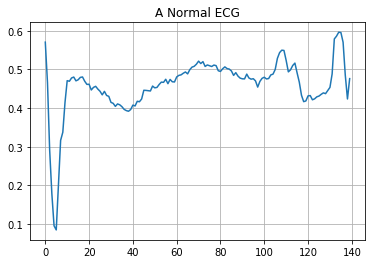

In [25]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

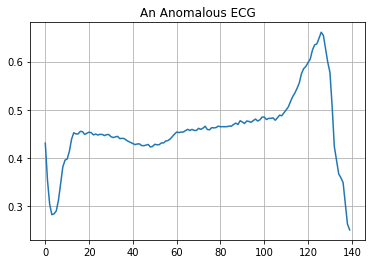

In [26]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [27]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(32, activation="relu"),
          layers.Dense(16, activation="relu"),
          layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(140, activation="sigmoid")])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [29]:
autoencoder.compile(optimizer='adam', loss='mae')
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0585 - val_loss: 0.0536
Epoch 2/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0567 - val_loss: 0.0524
Epoch 3/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0547 - val_loss: 0.0510
Epoch 4/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0517 - val_loss: 0.0496
Epoch 5/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0480 - val_loss: 0.0479
Epoch 6/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0439 - val_loss: 0.0455
Epoch 7/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0398 - val_loss: 0.0436
Epoch 8/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0365 - val_loss: 0.0422
Epoch 9/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0339 - val_loss: 0.0406
Epoch 10/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0316 - val_loss: 0.0396
Epoch 11/20
5/5 [=====================

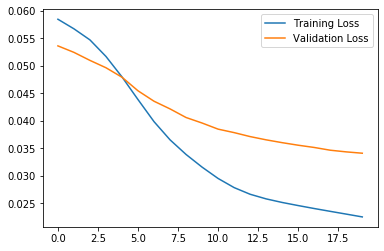

In [30]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.



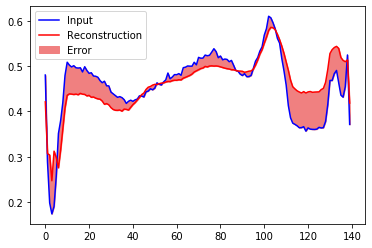

In [31]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

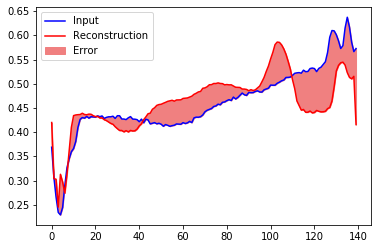

In [32]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()



**Detect anomalies**

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

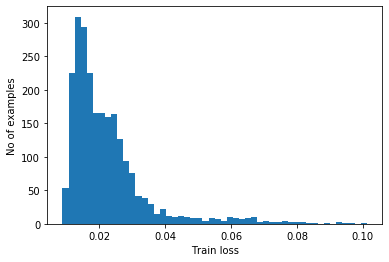

Threshold:  0.034265943


In [33]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

In [34]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, preds)))
    print("Precision = {}".format(precision_score(labels, preds)))
    print("Recall = {}".format(recall_score(labels, preds)))

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9921722113502935
Recall = 0.9053571428571429
